In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from string import punctuation 
from textblob import TextBlob

from nltk import pos_tag
from nltk.corpus import wordnet, stopwords
stop_words = stopwords.words("english")
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

from sklearn.linear_model import LogisticRegression

In [3]:
def get_wordnet_pos(pt):
    output = np.asarray(pt)
    for i in range(len(pt)):
        if pt[i][1].startswith('J'):
            output[i][1] = wordnet.ADJ
        elif pt[i][1].startswith('V'):
            output[i][1] = wordnet.VERB
        elif pt[i][1].startswith('R'):
            output[i][1] = wordnet.ADV
        else:
            output[i][1] = wordnet.NOUN
    return output

def lem_stem(text, preprocessing='stem', join=False):
    # Tokenize
    tokens = word_tokenize(text)
    # Get rid of punctuation
    tokens = [t for t in tokens if t.isalpha()]
    # Get rid of stopwords

In [4]:
pd.__version__

'2.0.2'

In [5]:
#tweets = pd.read_csv('trump_tweet_2016.csv')

In [6]:
tweets = pd.read_csv('trump_tweet_2016.csv', on_bad_lines="skip", sep='|')

In [7]:
tweets.text[2]

"Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do. Love!"

In [8]:
tweets['source'].value_counts()

source
Twitter for iPhone     1823
Twitter for Android    1690
Twitter Web Client      316
Twitter Ads              63
Twitter for iPad         19
TweetDeck                 2
Instagram                 2
Periscope                 1
Media Studio              1
Mobile Web (M5)           1
Name: count, dtype: int64

In [9]:
tweets.rename(columns={"source": "target_name"}, inplace=True)

In [10]:
tweets.reset_index(inplace=True, drop=True)

In [11]:
tweets.shape

(3918, 7)

In [12]:
tweets = tweets.drop('id_str', axis=1)

In [13]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3918 entries, 0 to 3917
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   target_name     3918 non-null   object
 1   text            3918 non-null   object
 2   created_at      3918 non-null   object
 3   retweet_count   3918 non-null   int64 
 4   favorite_count  3918 non-null   int64 
 5   is_retweet      3918 non-null   bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 157.0+ KB


In [14]:
tweets.isna().sum()

target_name       0
text              0
created_at        0
retweet_count     0
favorite_count    0
is_retweet        0
dtype: int64

In [15]:
tweets["target_name"].unique()

array(['Twitter for iPhone', 'Twitter for Android', 'Twitter Web Client',
       'Twitter Ads', 'Periscope', 'Twitter for iPad', 'TweetDeck',
       'Media Studio', 'Instagram', 'Mobile Web (M5)'], dtype=object)

In [16]:
tweets = tweets[(tweets["target_name"] == "Twitter for iPhone") | (tweets["target_name"] == "Twitter for Android")]

In [17]:
tweets

,target_name,text,created_at,retweet_count,favorite_count,is_retweet
0,Twitter for iPhone,RT @realDonaldTrump: Happy Birthday @DonaldJTr...,12-31-2016 18:59:04,9529,0,True
1,Twitter for iPhone,Happy Birthday @DonaldJTrumpJr!https://t.co/uR...,12-31-2016 18:58:12,9529,55601,False
2,Twitter for Android,"Happy New Year to all, including to my many en...",12-31-2016 13:17:21,141853,350860,False
3,Twitter for Android,Russians are playing @CNN and @NBCNews for suc...,12-30-2016 22:18:18,23213,84254,False
4,Twitter for iPhone,"Join @AmerIcan32, founded by Hall of Fame lege...",12-30-2016 19:46:55,7366,25336,False
...,...,...,...,...,...,...
3913,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,01-01-2016 05:18:23,3434,9143,False
3914,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,01-01-2016 03:25:27,3460,8581,False
3915,Twitter for Android,"I will be on @FoxNews live, with members of m...",01-01-2016 00:44:14,2108,6735,False
3916,Twitter for Android,I would like to wish everyone A HAPPY AND HEAL...,12-31-2015 23:21:49,6776,16495,False


In [18]:
tweets.reset_index(inplace=True, drop=True)

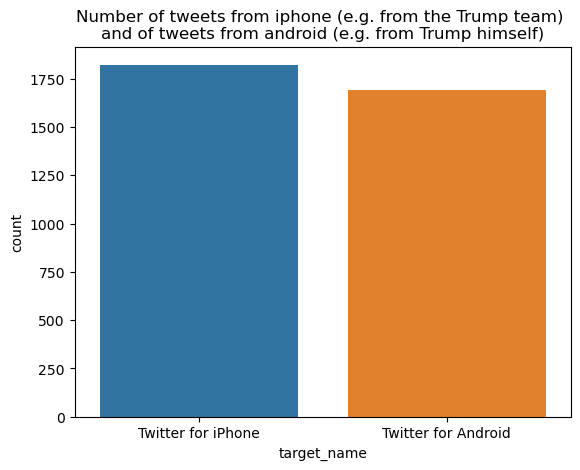

In [19]:
plt.figure()

sns.countplot(tweets.target_name)
plt.title("Number of tweets from iphone (e.g. from the Trump team) \nand of tweets from android (e.g. from Trump himself)")

plt.show()

In [20]:
tweets.is_retweet = tweets.is_retweet.astype(int)

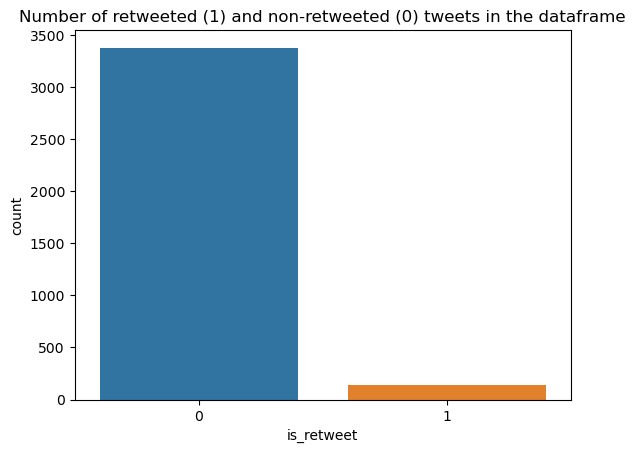

In [21]:
plt.figure()

sns.countplot(tweets.is_retweet)
plt.title("Number of retweeted (1) and non-retweeted (0) tweets in the dataframe")

plt.show()

In [22]:
tweets["favorite_count"] = tweets["favorite_count"].replace(0, int(tweets["favorite_count"].mean()))

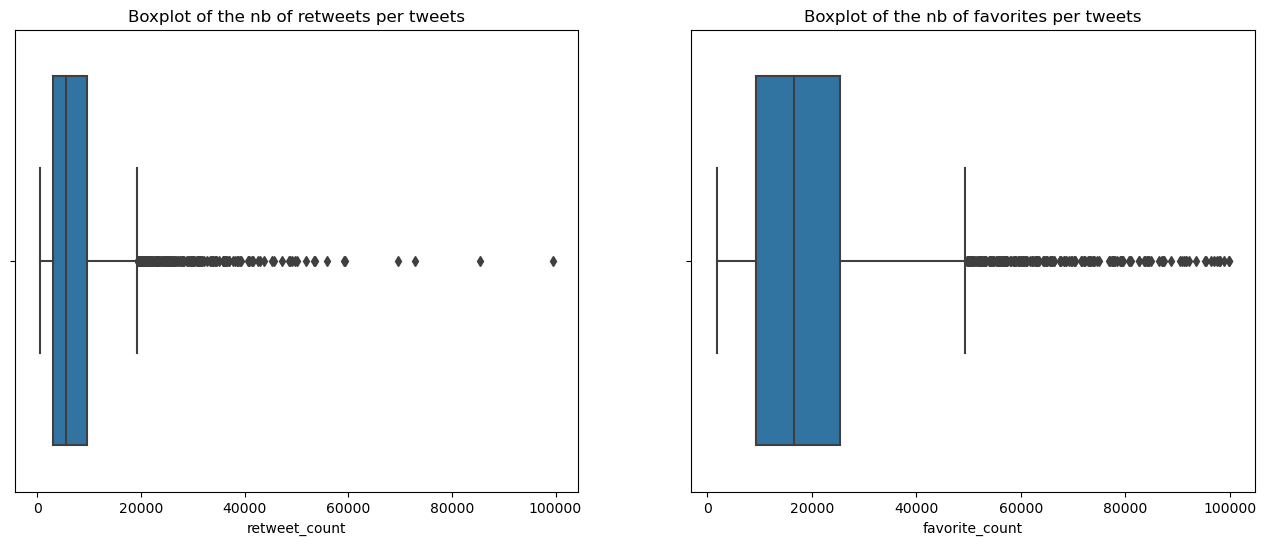

In [23]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
sns.boxplot(tweets.retweet_count[tweets.retweet_count < 100000])
plt.title("Boxplot of the nb of retweets per tweets")

plt.subplot(122)
sns.boxplot(tweets.favorite_count[tweets.favorite_count < 100000])
plt.title("Boxplot of the nb of favorites per tweets")

plt.show()

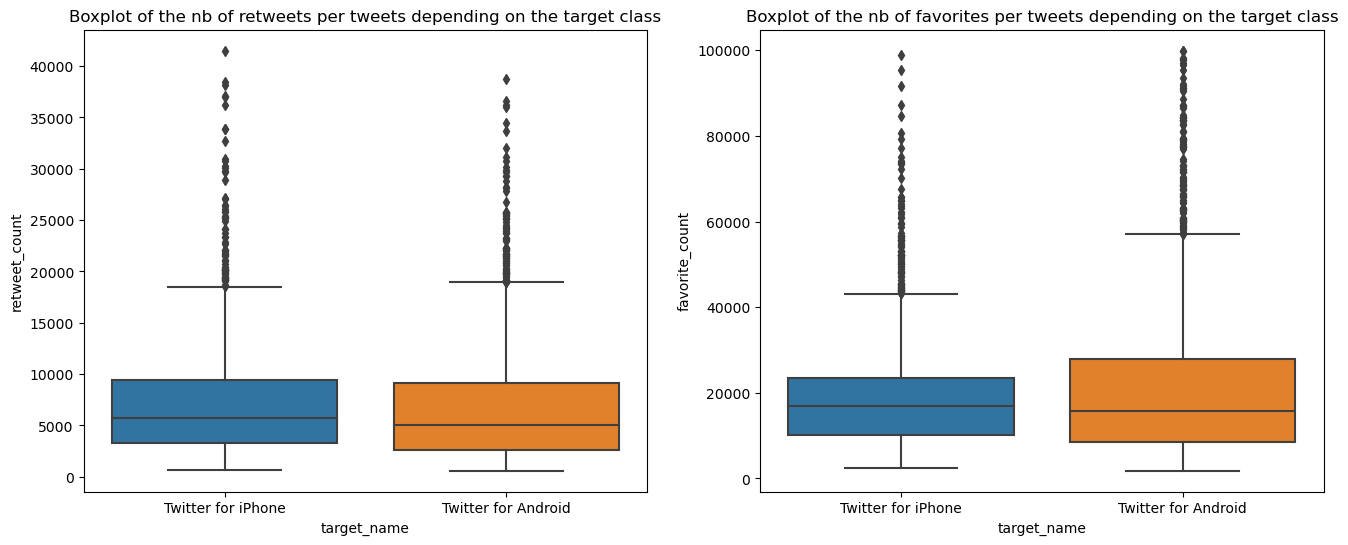

In [24]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
sns.boxplot(data=tweets[tweets.favorite_count < 100000], 
            y='retweet_count', 
            x='target_name')
plt.title("Boxplot of the nb of retweets per tweets depending on the target class")

plt.subplot(122)
sns.boxplot(data=tweets[tweets.favorite_count < 100000], 
            y='favorite_count', 
            x='target_name')
plt.title("Boxplot of the nb of favorites per tweets depending on the target class")

plt.show()

In [25]:
tweets.groupby('target_name')[["retweet_count", "favorite_count"]].mean()

,retweet_count,favorite_count
target_name,,
Twitter for Android,8159.472189,25712.058580
Twitter for iPhone,7452.662095,20012.420735


In [26]:
tweets.created_at = pd.to_datetime(tweets.created_at)

In [27]:
tweets.created_at = tweets.created_at.dt.tz_localize('Europe/Paris').dt.tz_convert('US/Eastern')

In [28]:
tweets.created_at.min(), tweets.created_at.max()

(Timestamp('2015-12-31 17:11:35-0500', tz='US/Eastern'),
 Timestamp('2016-12-31 12:59:04-0500', tz='US/Eastern'))

In [29]:
# Feature engineering 

# Get a column "Hour"
tweets["Hour"] = tweets["created_at"].apply(lambda x: x.hour)

# Get a column "Weekday"
tweets["weekday"] = tweets["created_at"].apply(lambda x: x.weekday())

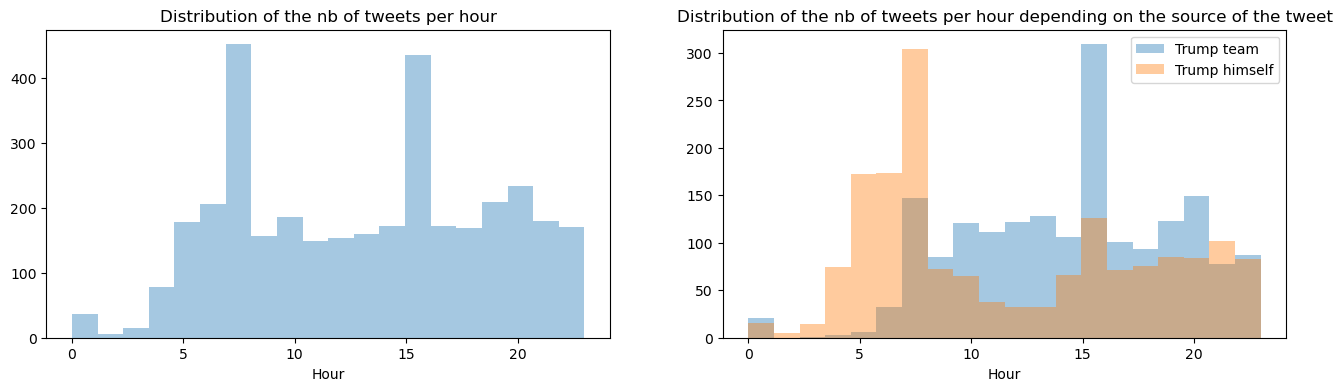

In [30]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
sns.distplot(tweets.Hour, kde=False, bins=20)
plt.title("Distribution of the nb of tweets per hour")

plt.subplot(122)
sns.distplot(tweets.Hour[tweets.target_name == "Twitter for iPhone"], label="Trump team", kde=False, bins=20)
sns.distplot(tweets.Hour[tweets.target_name == "Twitter for Android"], label="Trump himself", kde=False, bins=20)
plt.title("Distribution of the nb of tweets per hour depending on the source of the tweet")
plt.legend()

plt.show()

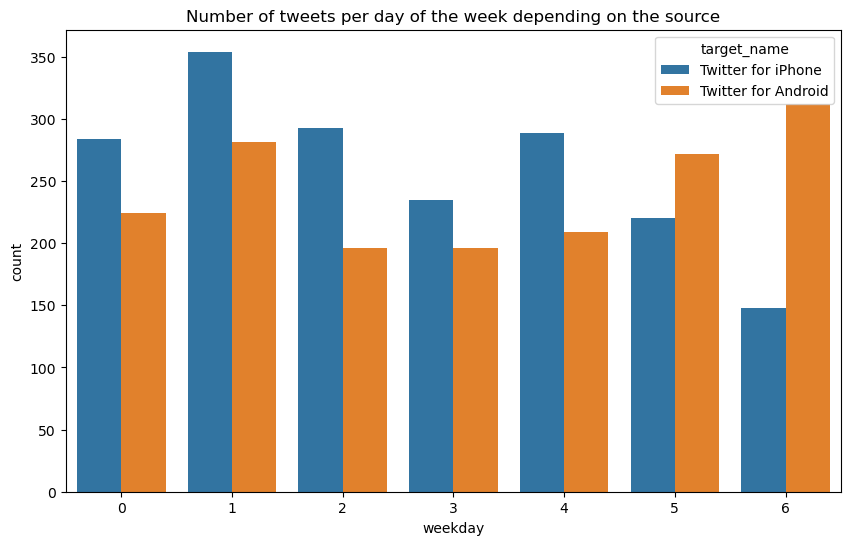

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(tweets.weekday, hue=tweets.target_name)
plt.title("Number of tweets per day of the week depending on the source")
plt.show()

In [32]:
tweets = pd.get_dummies(tweets, columns=['weekday'], drop_first=True)

In [33]:
tweets['length_of_tweet'] = tweets.text.apply(lambda x : len(word_tokenize(x)))
tweets["punctuation_length"] = tweets.text.apply(lambda x : len([w for w in x if w in punctuation]))
tweets['num_of_unique_words'] = tweets.text.apply(lambda x: len(set(word_tokenize(x))))
tweets['number_of_characters'] = tweets.text.apply(len)

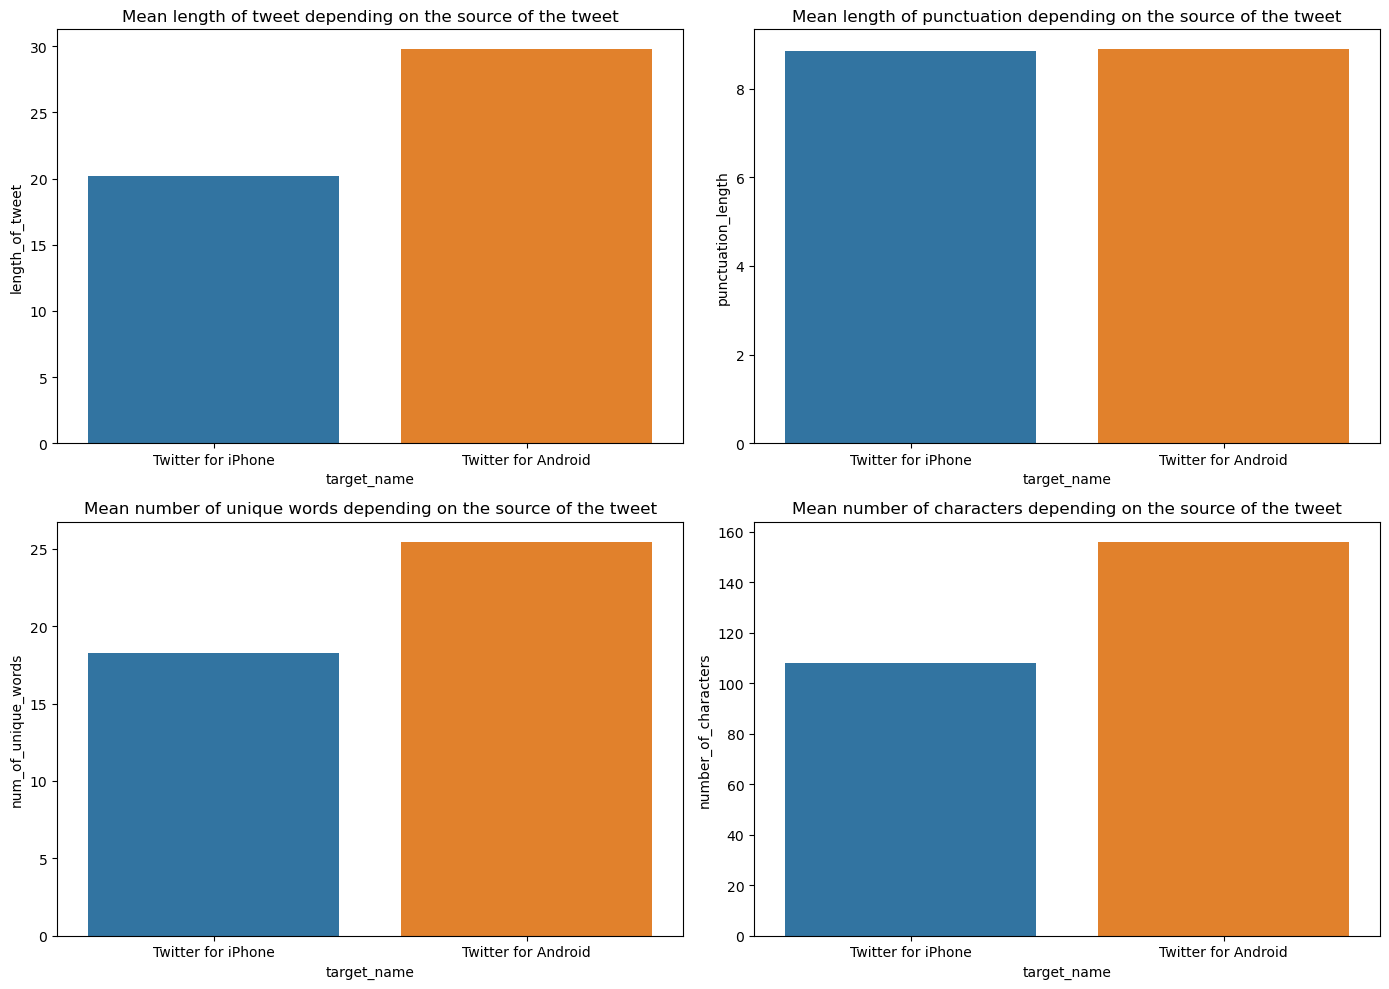

In [34]:
plt.figure(figsize=(14, 10))

plt.subplot(221)
sns.barplot(x=tweets.target_name, y=tweets.length_of_tweet, ci=None)
plt.title("Mean length of tweet depending on the source of the tweet")

plt.subplot(222)
sns.barplot(x=tweets.target_name, y=tweets.punctuation_length, ci=None)
plt.title("Mean length of punctuation depending on the source of the tweet")

plt.subplot(223)
sns.barplot(x=tweets.target_name, y=tweets.num_of_unique_words, ci=None)
plt.title("Mean number of unique words depending on the source of the tweet")

plt.subplot(224)
sns.barplot(x=tweets.target_name, y=tweets.number_of_characters, ci=None)
plt.title("Mean number of characters depending on the source of the tweet")

plt.tight_layout()

In [35]:
tweets

,target_name,text,created_at,retweet_count,favorite_count,is_retweet,Hour,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,length_of_tweet,punctuation_length,num_of_unique_words,number_of_characters
0,Twitter for iPhone,RT @realDonaldTrump: Happy Birthday @DonaldJTr...,2016-12-31 12:59:04-05:00,9529,21906,1,12,False,False,False,False,True,False,12,9,10,75
1,Twitter for iPhone,Happy Birthday @DonaldJTrumpJr!https://t.co/uR...,2016-12-31 12:58:12-05:00,9529,55601,0,12,False,False,False,False,True,False,8,7,8,54
2,Twitter for Android,"Happy New Year to all, including to my many en...",2016-12-31 07:17:21-05:00,141853,350860,0,7,False,False,False,False,True,False,32,4,28,137
3,Twitter for Android,Russians are playing @CNN and @NBCNews for suc...,2016-12-30 16:18:18-05:00,23213,84254,0,16,False,False,False,True,False,False,29,8,26,121
4,Twitter for iPhone,"Join @AmerIcan32, founded by Hall of Fame lege...",2016-12-30 13:46:55-05:00,7366,25336,0,13,False,False,False,True,False,False,21,13,19,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,2015-12-31 23:18:23-05:00,3434,9143,0,23,False,False,True,False,False,False,6,7,6,45
3509,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,2015-12-31 21:25:27-05:00,3460,8581,0,21,False,False,True,False,False,False,15,13,13,79
3510,Twitter for Android,"I will be on @FoxNews live, with members of m...",2015-12-31 18:44:14-05:00,2108,6735,0,18,False,False,True,False,False,False,31,8,28,134
3511,Twitter for Android,I would like to wish everyone A HAPPY AND HEAL...,2015-12-31 17:21:49-05:00,6776,16495,0,17,False,False,True,False,False,False,30,4,27,139


In [36]:
import re

In [37]:
cleaners = ['rt', 'realdonaldtrump', 'amp', 'http', 'donaldjtrumpjr']

In [38]:
def process(document):
    document = cleanre(document)
    tokens = word_tokenize(document)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [stemmer.stem(t) for t in tokens]
    tokens = [t for t in tokens if t not in cleaners]
    return tokens

In [39]:
tweets['text'][0]

'RT @realDonaldTrump: Happy Birthday @DonaldJTrumpJr!https://t.co/uRxyCD3hBz'

In [40]:
def cleanre(x):
    y=x
    y=re.sub(r'@\w+', '', y)
    y=re.sub(r'https(.*)', '', y)
    y=re.sub(r'#(.*)', '', y)
    return y

In [41]:
cleanre(tweets['text'][2])

"Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do. Love!"

In [42]:
tweets['processed'] = tweets['text'].apply(process)

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

In [44]:
tweets['processed']

0                                       [happi, birthday]
1                                       [happi, birthday]
2       [happi, new, year, includ, mani, enemi, fought...
3       [russian, play, fool, funni, watch, clue, tota...
4           [join, found, hall, fame, legend, washington]
                              ...                        
3508                                                   []
3509                            [happi, new, year, thank]
3510    [live, member, famili, ring, new, year, togeth...
3511    [would, like, wish, everyon, happi, healthi, n...
3512    [believ, state, depart, new, year, eve, releas...
Name: processed, Length: 3513, dtype: object

In [45]:
vectorizer = CountVectorizer(stop_words='english', analyzer=lambda x: x)
BOW = vectorizer.fit_transform(tweets['processed']).toarray()
BOW.shape

(3513, 3687)

In [46]:
bow_df = pd.DataFrame(BOW, columns=vectorizer.get_feature_names_out())

In [47]:
bow_df

,abandon,abc,abdeslam,abedin,aberdeen,abil,abingdon,abl,aboard,abolish,...,youth,youtub,yr,yup,zealand,zero,zilch,zogbi,zuckerman,ĺ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3509,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
tweets.columns

Index(['target_name', 'text', 'created_at', 'retweet_count', 'favorite_count',
       'is_retweet', 'Hour', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'length_of_tweet',
       'punctuation_length', 'num_of_unique_words', 'number_of_characters',
       'processed'],
      dtype='object')

In [49]:
bow_df.columns

Index(['abandon', 'abc', 'abdeslam', 'abedin', 'aberdeen', 'abil', 'abingdon',
       'abl', 'aboard', 'abolish',
       ...
       'youth', 'youtub', 'yr', 'yup', 'zealand', 'zero', 'zilch', 'zogbi',
       'zuckerman', 'ĺ'],
      dtype='object', length=3687)

In [50]:
DF1 = tweets[[ 'retweet_count', 'favorite_count',
       'is_retweet', 'Hour', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'length_of_tweet',
       'punctuation_length', 'num_of_unique_words', 'number_of_characters']]

In [51]:
DF1

,retweet_count,favorite_count,is_retweet,Hour,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,length_of_tweet,punctuation_length,num_of_unique_words,number_of_characters
0,9529,21906,1,12,False,False,False,False,True,False,12,9,10,75
1,9529,55601,0,12,False,False,False,False,True,False,8,7,8,54
2,141853,350860,0,7,False,False,False,False,True,False,32,4,28,137
3,23213,84254,0,16,False,False,False,True,False,False,29,8,26,121
4,7366,25336,0,13,False,False,False,True,False,False,21,13,19,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508,3434,9143,0,23,False,False,True,False,False,False,6,7,6,45
3509,3460,8581,0,21,False,False,True,False,False,False,15,13,13,79
3510,2108,6735,0,18,False,False,True,False,False,False,31,8,28,134
3511,6776,16495,0,17,False,False,True,False,False,False,30,4,27,139


In [52]:
DF = pd.concat([DF1, bow_df], axis = 1)

In [53]:
from sklearn.preprocessing import StandardScaler

In [54]:
sc= StandardScaler()

In [55]:
tweets["label"] = tweets["target_name"].replace({'Twitter for iPhone':0, 'Twitter for Android':1})

In [56]:
tweets["label"].value_counts()

label
0    1823
1    1690
Name: count, dtype: int64

# FULL DF

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(DF,tweets["label"], test_size=0.2, random_state=0, 
                                                    stratify=tweets["label"])
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [58]:
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [59]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [60]:
lr = LogisticRegression(C=1.0)
lr.fit(X_train_scaled, y_train)

y_pred_train = lr.predict(X_train_scaled)
y_pred = lr.predict(X_test_scaled)

print("Accuracy sur le train : ", f1_score(y_train, y_pred_train))
print("Accuracy sur le test : ", f1_score(y_test, y_pred))
print('\n----------------------------\n')
print("Classification report sur le test : \n", classification_report(y_test, y_pred))

Accuracy sur le train :  0.9865871833084949
Accuracy sur le test :  0.717948717948718

----------------------------

Classification report sur le test : 
               precision    recall  f1-score   support

           0       0.74      0.76      0.75       365
           1       0.73      0.70      0.72       338

    accuracy                           0.73       703
   macro avg       0.73      0.73      0.73       703
weighted avg       0.73      0.73      0.73       703



In [61]:
confusion_matrix(y_test, y_pred)

array([[278,  87],
       [100, 238]], dtype=int64)

In [62]:
import xgboost as xgb

In [63]:
GBC = xgb.XGBClassifier()
GBC.fit(X_train_scaled, y_train)

y_pred_train = GBC.predict(X_train_scaled)
y_pred = GBC.predict(X_test_scaled)

print("F1score sur le train : ", f1_score(y_train, y_pred_train))
print("F1score sur le test : ", f1_score(y_test, y_pred))
print('\n----------------------------\n')
print("Classification report sur le test : \n", classification_report(y_test, y_pred))

F1score sur le train :  0.9803630974434977
F1score sur le test :  0.8513119533527697

----------------------------

Classification report sur le test : 
               precision    recall  f1-score   support

           0       0.87      0.85      0.86       365
           1       0.84      0.86      0.85       338

    accuracy                           0.85       703
   macro avg       0.85      0.86      0.85       703
weighted avg       0.86      0.85      0.85       703



In [65]:
# from sklearn.model_selection import GridSearchCV

# tuned_parameters = [{'max_depth': [10, 100, 1000], 'n_estimators': [10, 30, 100], 'learning_rate': [0.01, 0.1],
#                      'subsample':[1, 0.9, 0.8]}]

# clf = GridSearchCV(xgb.XGBClassifier(), tuned_parameters, cv=5, scoring='f1')
# clf.fit(X_train_scaled, y_train)

# y_pred_train = clf.predict(X_train_scaled)
# y_pred = clf.predict(X_test_scaled)

# print("F1score sur le train : ", f1_score(y_train, y_pred_train))
# print("F1score sur le test : ", f1_score(y_test, y_pred))
# print('\n----------------------------\n')
# print("Classification report sur le test : \n", classification_report(y_test, y_pred))

In [66]:
print("F1score sur le train : ", f1_score(y_train, y_pred_train))
print("F1score sur le test : ", f1_score(y_test, y_pred))
print('\n----------------------------\n')
print("Classification report sur le test : \n", classification_report(y_test, y_pred))

F1score sur le train :  0.9803630974434977
F1score sur le test :  0.8513119533527697

----------------------------

Classification report sur le test : 
               precision    recall  f1-score   support

           0       0.87      0.85      0.86       365
           1       0.84      0.86      0.85       338

    accuracy                           0.85       703
   macro avg       0.85      0.86      0.85       703
weighted avg       0.86      0.85      0.85       703



# DF feature engineering only

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(DF1,tweets["label"], test_size=0.2, random_state=0, 
                                                    stratify=tweets["label"])
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [69]:
# from sklearn.model_selection import GridSearchCV

# tuned_parameters = [{'max_depth': [10, 100, 1000], 'n_estimators': [10, 30, 100], 'learning_rate': [0.01, 0.1],
#                      'subsample':[1, 0.9, 0.8]}]

# clf = GridSearchCV(xgb.XGBClassifier(), tuned_parameters, cv=5, scoring='f1')
# clf.fit(X_train_scaled, y_train)

# y_pred_train = clf.predict(X_train_scaled)
# y_pred = clf.predict(X_test_scaled)

# print("F1score sur le train : ", f1_score(y_train, y_pred_train))
# print("F1score sur le test : ", f1_score(y_test, y_pred))
# print('\n----------------------------\n')
# print("Classification report sur le test : \n", classification_report(y_test, y_pred))

In [70]:
print("F1score sur le train : ", f1_score(y_train, y_pred_train))
print("F1score sur le test : ", f1_score(y_test, y_pred))
print('\n----------------------------\n')
print("Classification report sur le test : \n", classification_report(y_test, y_pred))

F1score sur le train :  0.9803630974434977
F1score sur le test :  0.8513119533527697

----------------------------

Classification report sur le test : 
               precision    recall  f1-score   support

           0       0.87      0.85      0.86       365
           1       0.84      0.86      0.85       338

    accuracy                           0.85       703
   macro avg       0.85      0.86      0.85       703
weighted avg       0.86      0.85      0.85       703



# BOW only

In [103]:
x = tweets['text'].apply(process)

In [104]:
y = tweets['target_name'].replace({'Twitter for iPhone':0, 'Twitter for Android':1})

In [105]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0, 
                                                    stratify=y)

In [106]:
vectorizer = CountVectorizer(analyzer=lambda x: x)

In [107]:
vectorizer.fit(X_train)

CountVectorizer(analyzer=<function <lambda> at 0x000002B04DF3A310>)

In [108]:
X_train_bow = pd.DataFrame(vectorizer.transform(X_train).toarray(), columns=vectorizer.get_feature_names_out())
X_test_bow = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns=vectorizer.get_feature_names_out())

In [109]:
GBC = xgb.XGBClassifier()
GBC.fit(X_train_bow, y_train)

y_pred_train = GBC.predict(X_train_bow)
y_pred = GBC.predict(X_test_bow)

print("F1score sur le train : ", f1_score(y_train, y_pred_train))
print("F1score sur le test : ", f1_score(y_test, y_pred))
print('\n----------------------------\n')
print("Classification report sur le test : \n", classification_report(y_test, y_pred))

F1score sur le train :  0.8577929465301479
F1score sur le test :  0.7006172839506173

----------------------------

Classification report sur le test : 
               precision    recall  f1-score   support

           0       0.72      0.77      0.74       365
           1       0.73      0.67      0.70       338

    accuracy                           0.72       703
   macro avg       0.72      0.72      0.72       703
weighted avg       0.72      0.72      0.72       703



# BOW only - with no prepro (done by count vecto)

In [110]:
x = tweets['text']
y = tweets['target_name'].replace({'Twitter for iPhone':0, 'Twitter for Android':1})

In [111]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0, 
                                                    stratify=y)

In [112]:
vectorizer = CountVectorizer(stop_words='english')

In [113]:
vectorizer.fit(X_train)

CountVectorizer(stop_words='english')

In [114]:
X_train_bow = pd.DataFrame(vectorizer.transform(X_train).toarray(), columns=vectorizer.get_feature_names_out())
X_test_bow = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns=vectorizer.get_feature_names_out())

In [115]:
GBC = xgb.XGBClassifier()
GBC.fit(X_train_bow, y_train)

y_pred_train = GBC.predict(X_train_bow)
y_pred = GBC.predict(X_test_bow)

print("F1score sur le train : ", f1_score(y_train, y_pred_train))
print("F1score sur le test : ", f1_score(y_test, y_pred))
print('\n----------------------------\n')
print("Classification report sur le test : \n", classification_report(y_test, y_pred))

F1score sur le train :  0.9121574139142656
F1score sur le test :  0.8551724137931035

----------------------------

Classification report sur le test : 
               precision    recall  f1-score   support

           0       0.91      0.79      0.85       365
           1       0.80      0.92      0.86       338

    accuracy                           0.85       703
   macro avg       0.86      0.85      0.85       703
weighted avg       0.86      0.85      0.85       703



# BOW only - with no prepro (done by count vecto) - reduced max features to 20

In [116]:
x = tweets['text']
y = tweets['target_name'].replace({'Twitter for iPhone':0, 'Twitter for Android':1})

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0, 
                                                    stratify=y)

In [138]:
vectorizer = CountVectorizer(stop_words='english', max_features=20)

In [139]:
vectorizer.fit(X_train)

CountVectorizer(max_features=20, stop_words='english')

In [140]:
X_train_bow = pd.DataFrame(vectorizer.transform(X_train).toarray(), columns=vectorizer.get_feature_names_out())
X_test_bow = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns=vectorizer.get_feature_names_out())

In [141]:
GBC = xgb.XGBClassifier()
GBC.fit(X_train_bow, y_train)

y_pred_train = GBC.predict(X_train_bow)
y_pred = GBC.predict(X_test_bow)

print("F1score sur le train : ", f1_score(y_train, y_pred_train))
print("F1score sur le test : ", f1_score(y_test, y_pred))
print('\n----------------------------\n')
print("Classification report sur le test : \n", classification_report(y_test, y_pred))

F1score sur le train :  0.8466957396846696
F1score sur le test :  0.8216216216216216

----------------------------

Classification report sur le test : 
               precision    recall  f1-score   support

           0       0.89      0.73      0.80       365
           1       0.76      0.90      0.82       338

    accuracy                           0.81       703
   macro avg       0.82      0.82      0.81       703
weighted avg       0.82      0.81      0.81       703



### with only 20 features, the model runs faster and is performing not so bad

In [152]:
f"tokens/features that count the most are : {' | '.join(vectorizer.get_feature_names_out())}"

'tokens/features that count the most are : 2016 | america | amp | clinton | crooked | cruz | false | great | hillary | https | just | make | makeamericagreatagain | new | people | realdonaldtrump | thank | trump | trump2016 | twitter'